### Load the Original Mistral 7B model

In [3]:
import torch

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" # the device to load the model onto

torch.cuda.empty_cache()

# load the model like this, on aws ec2 g5 family remember the dtype should be bfloat16, otherwise out of memory
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

model_inputs = encodeds.to(device)
model.to(device)

generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

/home/gui/projects/cs245-llama-eval/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gui/projects/cs245-llama-eval/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
The attention mask and the pad token id were not set. As a consequence, you may obse

<s> [INST] What is your favourite condiment? [/INST] Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen! </s><s> [INST] Do you have mayonnaise recipes? [/INST] I've got a couple of great recipes for you - one for a classic mayonnaise and one for a Greek style yoghurt mayonnaise. Both are quick and easy to put together and a great addition to any dish!  industrios.co.uk

Ingredients:
- 2 large egg yolks
- 1 tbsp white wine vinegar
- 1 tsp Dijon mustard
- 1 tbsp fresh lemon juice
- 2 cloves of garlic, grated
- Salt and pepper, to taste
- 1 cup vegetable oil
- 1 cup olive oil

Instructions:
- In a food processor, combine the egg yolks, white wine vinegar, Dijon mustard, lemon juice, garlic, salt, and pepper. Process until smooth and creamy.
- With the food processor running on low, slowly pour in the vegetable oil and olive oil until fully incorporated and the sauce is thick and creamy.
-

### Load the INT8 quantized Mistral 7B model

In [ ]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer

torch.cuda.empty_cache()

device = "cuda" # the device to load the model onto

quantization_config = BitsAndBytesConfig(
    load_in_8bit = True,
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1/")

model_8bit = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1/", torch_dtype=torch.bfloat16,
                                                  device_map=device,
                                                  quantization_config=quantization_config)

messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

model_inputs = encodeds.to(device)
# model_8bit.to(device)

generated_ids = model_8bit.generate(model_inputs, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

### Log in hugging face with access token in order to read/write to your repo

In [3]:
from huggingface_hub import notebook_login

notebook_login()

### Push the model to the repo

In [ ]:
model_8bit.push_to_hub('q8bit')

# The Benchmark for memory and latency

### Benchmark for different batch size

In [1]:
from optimum_benchmark.logging_utils import setup_logging
from optimum_benchmark.experiment import launch, ExperimentConfig
from optimum_benchmark.backends.pytorch.config import PyTorchConfig
from optimum_benchmark.launchers.torchrun.config import TorchrunConfig
from optimum_benchmark.benchmarks.inference.config import InferenceConfig

input_shapes={"batch_size": 1, "num_choices": 2, "seqeunce_length": 16}
l_ori = []
l_8bit = []
l_4bit = []

batch_step = 5

for i in range(1, 10):
    input_shapes["batch_size"] = i * 5
    
    try:
        setup_logging(level="INFO")
        launcher_config = TorchrunConfig(nproc_per_node=1)
        benchmark_config = InferenceConfig(latency=True, memory=True, input_shapes=input_shapes)
        backend_config = PyTorchConfig(model="mistralai/Mistral-7B-v0.1", device="cuda", device_ids="0",
                                      torch_dtype="bfloat16", quantization_scheme="bnb",
                                      quantization_config={"load_in_4bit": True})
        experiment_config = ExperimentConfig(
            experiment_name="api-launch",
            benchmark=benchmark_config,
            launcher=launcher_config,
            backend=backend_config,
        )
        benchmark_report = launch(experiment_config)
        
        # experiment_config.push_to_hub("AwAppp/benchmarks_8bit_batch_size"+str(i * batch_step))
        benchmark_report.push_to_hub("AwAppp/benchmarks_4bit_batch_size"+str(i * batch_step))
        
        l_4bit += [benchmark_report.to_dict()]
        
    except:
        break

for i in range(1, 10):
    input_shapes["batch_size"] = i * batch_step
    
    try:
        setup_logging(level="INFO")
        launcher_config = TorchrunConfig(nproc_per_node=1)
        benchmark_config = InferenceConfig(latency=True, memory=True)
        backend_config = PyTorchConfig(model="mistralai/Mistral-7B-v0.1", device="cuda", device_ids="0", no_weights=True, torch_dtype='bfloat16')
        experiment_config = ExperimentConfig(
            experiment_name="api-launch",
            benchmark=benchmark_config,
            launcher=launcher_config,
            backend=backend_config,
        )
        benchmark_report = launch(experiment_config)
        
        # experiment_config.push_to_hub("AwAppp/benchmarks_original_batch_size"+str(i * batch_step))
        benchmark_report.push_to_hub("AwAppp/benchmark_original_batch_size"+str(i * batch_step))
        
        l_ori += [benchmark_report.to_dict()]
        
    except:
        break
        
        
for i in range(1, 10):
    input_shapes["batch_size"] = i * 5
    
    try:
        setup_logging(level="INFO")
        launcher_config = TorchrunConfig(nproc_per_node=1)
        benchmark_config = InferenceConfig(latency=True, memory=True, input_shapes=input_shapes)
        backend_config = PyTorchConfig(model="AwAppp/q8bit", device="cuda", device_ids="0",
                                      torch_dtype="bfloat16", quantization_scheme="bnb",
                                      quantization_config={"load_in_8bit": True})
        experiment_config = ExperimentConfig(
            experiment_name="api-launch",
            benchmark=benchmark_config,
            launcher=launcher_config,
            backend=backend_config,
        )
        benchmark_report = launch(experiment_config)
        
        # experiment_config.push_to_hub("AwAppp/benchmarks_8bit_batch_size"+str(i * batch_step))
        benchmark_report.push_to_hub("AwAppp/benchmarks_8bit_batch_size"+str(i * batch_step))
        
        l_8bit += [benchmark_report.to_dict()]
        
    except:
        break
        
    # experiment_config.push_to_hub("IlyasMoutawwakil/benchmarks") # pushes experiment_config.json to the hub
    # benchmark_report.push_to_hub("IlyasMoutawwakil/benchmarks") # pushes benchmark_report.json to the hub

[2024-03-06 05:28:14,868][experiment][INFO] - Launching experiment in a temporary directory.
[2024-03-06 05:28:14,882][launcher][INFO] - ََAllocating torchrun launcher
[2024-03-06 05:28:14,883][torchrun][INFO] - 	+ Setting multiprocessing start method to spawn.
[2024-03-06 05:28:14,885][torchrun][INFO] - 	+ Launching torchrun agent with 1 workers processes
[RANK-0][2024-03-06 05:28:18,587][datasets][INFO] - PyTorch version 2.1.0 available.
[RANK-0][2024-03-06 05:28:19,191][backend][INFO] - َAllocating pytorch backend
[RANK-0][2024-03-06 05:28:19,191][backend][INFO] - 	+ Setting random seed to 42
[RANK-0][2024-03-06 05:28:20,415][pytorch][INFO] - 	+ Using AutoModel class AutoModelForCausalLM
[RANK-0][2024-03-06 05:28:20,415][pytorch][INFO] - 	+ Creating backend temporary directory
[RANK-0][2024-03-06 05:28:20,415][pytorch][INFO] - 	+ Loading model with random weights
[RANK-0][2024-03-06 05:28:20,415][pytorch][INFO] - 	+ Creating no weights model
[RANK-0][2024-03-06 05:28:20,415][pytorch

[2024-03-06 05:29:16,616][launcher][INFO] - ََAllocating torchrun launcher
[2024-03-06 05:29:16,617][torchrun][INFO] - 	+ Launching torchrun agent with 1 workers processes
[RANK-0][2024-03-06 05:29:20,241][datasets][INFO] - PyTorch version 2.1.0 available.
[RANK-0][2024-03-06 05:29:20,839][backend][INFO] - َAllocating pytorch backend
[RANK-0][2024-03-06 05:29:20,840][backend][INFO] - 	+ Setting random seed to 42
[RANK-0][2024-03-06 05:29:21,770][pytorch][INFO] - 	+ Using AutoModel class AutoModelForCausalLM
[RANK-0][2024-03-06 05:29:21,770][pytorch][INFO] - 	+ Creating backend temporary directory
[RANK-0][2024-03-06 05:29:21,771][pytorch][INFO] - 	+ Loading model with random weights
[RANK-0][2024-03-06 05:29:21,771][pytorch][INFO] - 	+ Creating no weights model
[RANK-0][2024-03-06 05:29:21,771][pytorch][INFO] - 	+ Creating no weights model directory
[RANK-0][2024-03-06 05:29:21,772][pytorch][INFO] - 	+ Creating no weights model state dict
[RANK-0][2024-03-06 05:29:21,790][pytorch][INFO

[RANK-0][2024-03-06 05:30:22,224][backend][INFO] - َAllocating pytorch backend
[RANK-0][2024-03-06 05:30:22,224][backend][INFO] - 	+ Setting random seed to 42
[RANK-0][2024-03-06 05:30:23,061][pytorch][INFO] - 	+ Using AutoModel class AutoModelForCausalLM
[RANK-0][2024-03-06 05:30:23,062][pytorch][INFO] - 	+ Creating backend temporary directory
[RANK-0][2024-03-06 05:30:23,062][pytorch][INFO] - 	+ Loading model with random weights
[RANK-0][2024-03-06 05:30:23,062][pytorch][INFO] - 	+ Creating no weights model
[RANK-0][2024-03-06 05:30:23,062][pytorch][INFO] - 	+ Creating no weights model directory
[RANK-0][2024-03-06 05:30:23,062][pytorch][INFO] - 	+ Creating no weights model state dict
[RANK-0][2024-03-06 05:30:23,082][pytorch][INFO] - 	+ Saving no weights model safetensors
[RANK-0][2024-03-06 05:30:23,083][pytorch][INFO] - 	+ Saving no weights model pretrained config
[RANK-0][2024-03-06 05:30:23,084][pytorch][INFO] - 	+ Loading no weights AutoModel
[RANK-0][2024-03-06 05:30:23,084][p

[RANK-0][2024-03-06 05:31:24,804][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:31:24,804][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:31:24,804][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:31:24,804][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:31:24,804][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:31:24,809][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:31:24,809][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:31:24,809][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:31:24,809][inference][INFO] - 	+ Warming up backend for Inference
[RANK-0][2024-03-06 05:31:26,197][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:31:26,198][memory][INFO] - 	+ Tracking RAM memory
[RANK

[RANK-0][2024-03-06 05:32:27,394][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:32:27,394][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:32:27,394][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:32:27,394][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:32:27,394][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:32:37,002][memory][INFO] - 		+ prefill max RAM memory: 1476.689920 (MB)
[RANK-0][2024-03-06 05:32:37,003][memory][INFO] - 		+ prefill max VRAM memory: 15674.114048 (MB)
[RANK-0][2024-03-06 05:32:37,003][memory][INFO] - 		+ prefill max reserved memory: 15189.671936 (MB)
[RANK-0][2024-03-06 05:32:37,003][memory][INFO] - 		+ prefill max allocated memory: 15039.572480 (MB)
[RANK-0][2024-03-06 05:32:37,003][memory][INFO] - 		+ decode max RAM memory: 1487.601664 (MB)
[RANK-0][2024-03-06 05:32:37,003][memory][INFO] - 		+ decod

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


[RANK-0][2024-03-06 05:33:34,075][pytorch][INFO] - 	+ Turning on model's eval mode
[RANK-0][2024-03-06 05:33:34,079][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:33:34,079][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:33:34,079][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:33:34,079][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:33:34,079][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:33:34,079][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:33:34,080][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:33:34,080][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:33:34,080][inference][INFO] - 	+ Warming up backend for Inference


/opt/conda/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[RANK-0][2024-03-06 05:33:37,157][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:33:37,158][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:33:37,158][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:33:37,158][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:33:37,158][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ prefill max RAM memory: 3430.653952 (MB)
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ prefill max VRAM memory: 8575.254528 (MB)
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ prefill max reserved memory: 8082.423808 (MB)
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ prefill max allocated memory: 8060.357120 (MB)
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ decode max RAM memory: 3440.074752 (MB)
[RANK-0][2024-03-06 05:33:53,843][memory][INFO] - 		+ decode m

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


[RANK-0][2024-03-06 05:34:35,418][pytorch][INFO] - 	+ Turning on model's eval mode
[RANK-0][2024-03-06 05:34:35,422][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:34:35,422][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:34:35,422][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:34:35,422][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:34:35,422][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:34:35,422][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:34:35,422][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:34:35,423][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:34:35,423][inference][INFO] - 	+ Warming up backend for Inference


/opt/conda/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[RANK-0][2024-03-06 05:34:38,067][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:34:38,067][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:34:38,068][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:34:38,068][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:34:38,068][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:34:54,967][memory][INFO] - 		+ prefill max RAM memory: 3369.394176 (MB)
[RANK-0][2024-03-06 05:34:54,967][memory][INFO] - 		+ prefill max VRAM memory: 8568.963072 (MB)
[RANK-0][2024-03-06 05:34:54,967][memory][INFO] - 		+ prefill max reserved memory: 8097.103872 (MB)
[RANK-0][2024-03-06 05:34:54,967][memory][INFO] - 		+ prefill max allocated memory: 8071.948800 (MB)
[RANK-0][2024-03-06 05:34:54,968][memory][INFO] - 		+ decode max RAM memory: 3373.498368 (MB)
[RANK-0][2024-03-06 05:34:54,968][memory][INFO] - 		+ decode m

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


[RANK-0][2024-03-06 05:35:37,116][pytorch][INFO] - 	+ Turning on model's eval mode
[RANK-0][2024-03-06 05:35:37,120][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:35:37,120][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:35:37,120][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:35:37,120][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:35:37,120][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:35:37,121][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:35:37,121][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:35:37,121][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:35:37,121][inference][INFO] - 	+ Warming up backend for Inference


/opt/conda/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[RANK-0][2024-03-06 05:35:39,689][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:35:39,689][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:35:39,689][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:35:39,689][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:35:39,690][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ prefill max RAM memory: 3364.429824 (MB)
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ prefill max VRAM memory: 8589.934592 (MB)
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ prefill max reserved memory: 8118.075392 (MB)
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ prefill max allocated memory: 8081.560064 (MB)
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ decode max RAM memory: 3364.429824 (MB)
[RANK-0][2024-03-06 05:35:56,299][memory][INFO] - 		+ decode m

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


[RANK-0][2024-03-06 05:36:39,568][pytorch][INFO] - 	+ Turning on model's eval mode
[RANK-0][2024-03-06 05:36:39,572][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:36:39,572][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:36:39,572][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:36:39,572][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:36:39,572][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:36:39,573][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:36:39,573][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:36:39,573][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:36:39,573][inference][INFO] - 	+ Warming up backend for Inference


/opt/conda/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[RANK-0][2024-03-06 05:36:42,187][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:36:42,187][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:36:42,187][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:36:42,187][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:36:42,187][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ prefill max RAM memory: 2256.003072 (MB)
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ prefill max VRAM memory: 8604.614656 (MB)
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ prefill max reserved memory: 8126.464000 (MB)
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ prefill max allocated memory: 8092.697088 (MB)
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ decode max RAM memory: 2256.003072 (MB)
[RANK-0][2024-03-06 05:36:58,979][memory][INFO] - 		+ decode m

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


[RANK-0][2024-03-06 05:37:40,600][pytorch][INFO] - 	+ Turning on model's eval mode
[RANK-0][2024-03-06 05:37:40,604][benchmark][INFO] - Allocating inference benchmark
[RANK-0][2024-03-06 05:37:40,604][inference][INFO] - 	+ Distributing batch size across processes
[RANK-0][2024-03-06 05:37:40,604][inference][INFO] - 	+ Creating input generator
[RANK-0][2024-03-06 05:37:40,604][input][INFO] - 	+ Using text-generation task generator
[RANK-0][2024-03-06 05:37:40,604][inference][INFO] - 	+ Generating and preparing Text Generation inputs
[RANK-0][2024-03-06 05:37:40,605][inference][INFO] - 	+ Updating Text Generation kwargs with default values
[RANK-0][2024-03-06 05:37:40,605][inference][INFO] - 	+ Initializing Text Generation report
[RANK-0][2024-03-06 05:37:40,605][inference][INFO] - 	+ Preparing backend for Inference
[RANK-0][2024-03-06 05:37:40,605][inference][INFO] - 	+ Warming up backend for Inference


/opt/conda/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[RANK-0][2024-03-06 05:37:43,334][inference][INFO] - 	+ Creating inference memory tracker
[RANK-0][2024-03-06 05:37:43,334][memory][INFO] - 	+ Tracking RAM memory
[RANK-0][2024-03-06 05:37:43,334][memory][INFO] - 	+ Tracking VRAM memory of CUDA devices: [0]
[RANK-0][2024-03-06 05:37:43,334][memory][INFO] - 	+ Tracking Allocated/Reserved memory of 1 Pytorch CUDA devices
[RANK-0][2024-03-06 05:37:43,334][inference][INFO] - 	+ Running memory tracking
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ prefill max RAM memory: 3363.545088 (MB)
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ prefill max VRAM memory: 8610.906112 (MB)
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ prefill max reserved memory: 8139.046912 (MB)
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ prefill max allocated memory: 8103.205376 (MB)
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ decode max RAM memory: 3369.660416 (MB)
[RANK-0][2024-03-06 05:38:00,219][memory][INFO] - 		+ decode m

### plot of the prefill benchmark

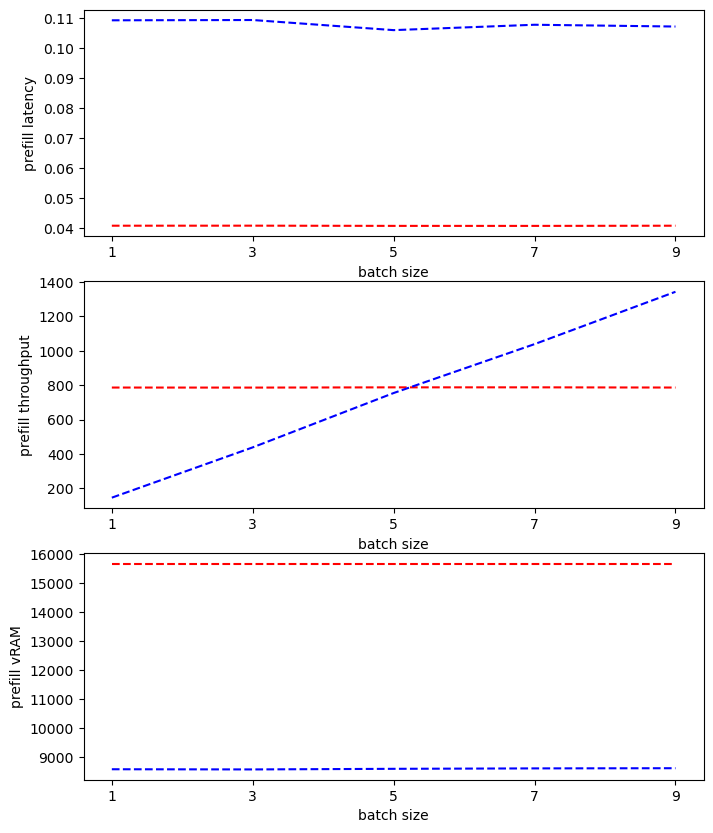

In [28]:
import matplotlib.pyplot as plt

x = []
for i in range(1, 10, 2):
    x += [i]
    
plt.figure(figsize=(8, 10))

plt.subplot(311)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('prefill latency')
prefill_latency_ori = list(map(lambda x: x['prefill']['latency']['mean'], l_ori))
prefill_latency_8bit = list(map(lambda x: x['prefill']['latency']['mean'], l_8bit))
plt.plot(prefill_latency_ori, 'r--', prefill_latency_8bit, 'b--')

plt.subplot(312)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('prefill throughput')
prefill_throughput_ori = list(map(lambda x: x['prefill']['throughput']['value'], l_ori))
prefill_throughput_8bit = list(map(lambda x: x['prefill']['throughput']['value'], l_8bit))
plt.plot(prefill_throughput_ori, 'r--', prefill_throughput_8bit, 'b--')

plt.subplot(313)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('prefill vRAM')
prefill_vram_ori = list(map(lambda x: x['prefill']['memory']['max_vram'], l_ori))
prefill_vram_8bit = list(map(lambda x: x['prefill']['memory']['max_vram'], l_8bit))
plt.plot(prefill_vram_ori, 'r--', prefill_vram_8bit, 'b--')

### plot of the decode benchmark

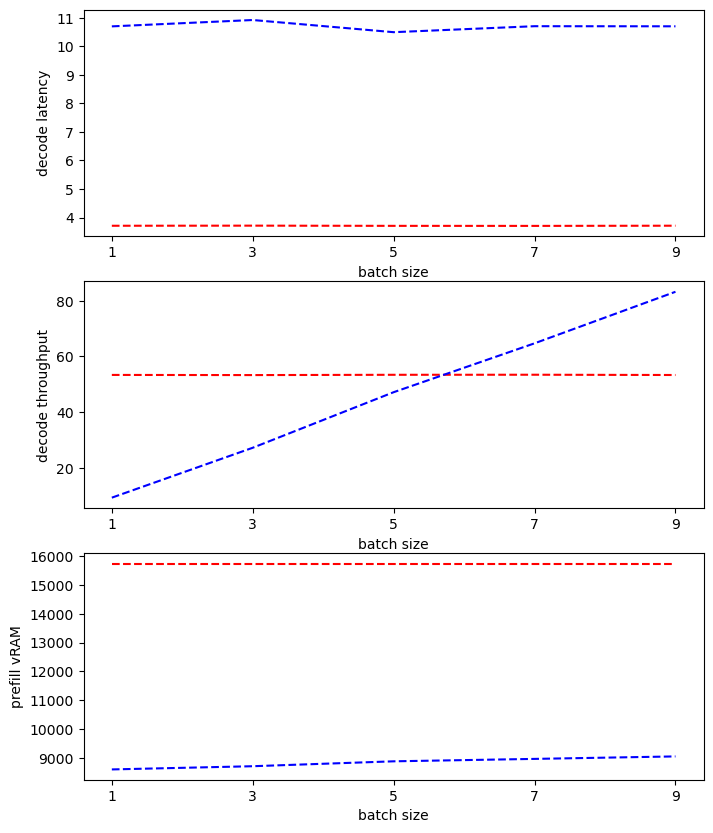

In [31]:
plt.figure(figsize=(8, 10))

plt.subplot(311)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('decode latency')
decode_latency_ori = list(map(lambda x: x['decode']['latency']['mean'], l_ori))
decode_latency_8bit = list(map(lambda x: x['decode']['latency']['mean'], l_8bit))
plt.plot(decode_latency_ori, 'r--', decode_latency_8bit, 'b--')

plt.subplot(312)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('decode throughput')
decode_throughput_ori = list(map(lambda x: x['decode']['throughput']['value'], l_ori))
decode_throughput_8bit = list(map(lambda x: x['decode']['throughput']['value'], l_8bit))
plt.plot(decode_throughput_ori, 'r--', decode_throughput_8bit, 'b--')

plt.subplot(313)
plt.xticks(range(len(x)), x)
plt.xlabel('batch size')
plt.ylabel('prefill vRAM')
decode_vram_ori = list(map(lambda x: x['decode']['memory']['max_vram'], l_ori))
decode_vram_8bit = list(map(lambda x: x['decode']['memory']['max_vram'], l_8bit))
plt.plot(decode_vram_ori, 'r--', decode_vram_8bit, 'b--')